## Lake Zug APhys-AChem Meeting (10/11/2025)

In [1]:
# imports
import os
from glob import glob
import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime
import re
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings; warnings.filterwarnings('ignore')

### Field Work

In [336]:
# Lake Zug bathymetry
bathy = xr.open_dataset('../../../data/lake_zug/bathymetry/zugersee_bathy.nc')

#### Mooring Deployment

In [337]:
mooring_locs = pd.DataFrame({
    'loc': ['LZC', 'LZE', 'LZW', 'LZN'],
    'xsc_plan': [2680090, 2680328, 2679884, 2679423],
    'ysc_plan': [1218816, 1218866, 1218764, 1219382],
    'xsc': [2680084, 2680314, 2679912, 2679436],
    'ysc': [1218840, 1218883, 1218770, 1219384]
})


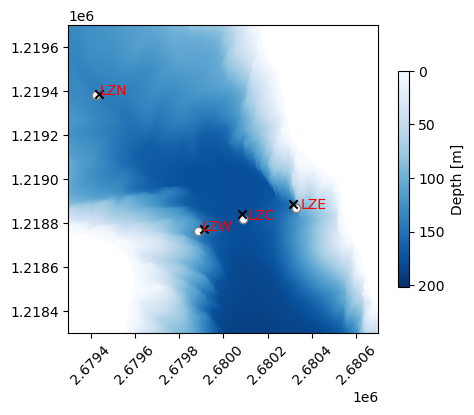

In [339]:
fig, ax = plt.subplots(figsize=(5, 4))

im = ax.pcolormesh(bathy['xsc'], bathy['ysc'], bathy['depth'], cmap='Blues', vmin=0)
cbar = fig.colorbar(im, shrink=0.7, label='Depth [m]', ax=ax)
cbar.ax.invert_yaxis()

for _, row in mooring_locs.iterrows():
    # planned locations
    ax.scatter(row.xsc_plan, row.ysc_plan, c='white', edgecolor='gray')
    ax.annotate(row['loc'], (row.xsc_plan, row.ysc_plan), color='red', xytext=(3, 0), textcoords='offset points')

    # deployed locations
    if not math.isnan(row.xsc) and not math.isnan(row.ysc):
        ax.scatter(row.xsc, row.ysc, c='black', marker='x')

ax.tick_params(axis='x', rotation=45)
ax.set_xlim(2679300, 2680700)
ax.set_ylim(1218300, 1219700)

plt.show()

#### CTD Transects

In [356]:
# planned locations
profile_locs = pd.DataFrame({
    'loc': [f'P{x}' for x in range(1, 13)],
    'xsc': [679803, 679803, 679663, 679415, 679505, 680030, 680150, 680223, 680409, 680814, 681350, 681909],
    'ysc': [224100, 222690, 221650, 220433, 219544, 218872, 218462, 218126, 217437, 216239, 214957, 213760]
})
profile_locs['xsc'] += int(2e6)
profile_locs['ysc'] += int(1e6)

profile_locs['depth'] = [bathy.sel(xsc=row.xsc, ysc=row.ysc).depth.item() for _, row in profile_locs.iterrows()]

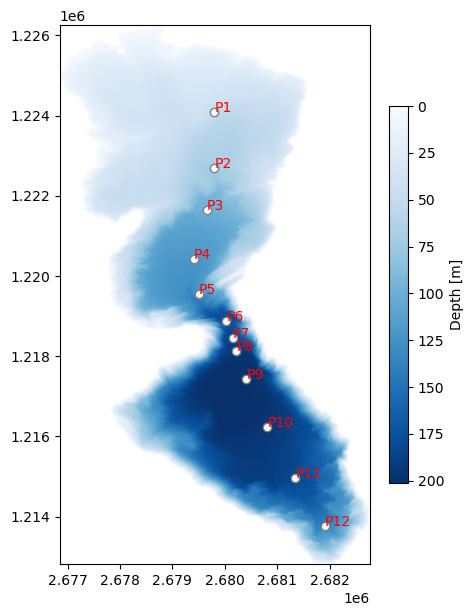

In [361]:
fig, ax = plt.subplots(figsize=(5, 7))

im = ax.pcolormesh(bathy['xsc'], bathy['ysc'], bathy['depth'], cmap='Blues', vmin=0)
cbar = fig.colorbar(im, shrink=0.7, label='Depth [m]', ax=ax)
cbar.ax.invert_yaxis()

# planned locations
for _, row in profile_locs.iterrows():
    ax.scatter(row.xsc, row.ysc, c='white', edgecolor='gray')
    ax.annotate(row['loc'], (row.xsc, row.ysc), color='red')

plt.show()

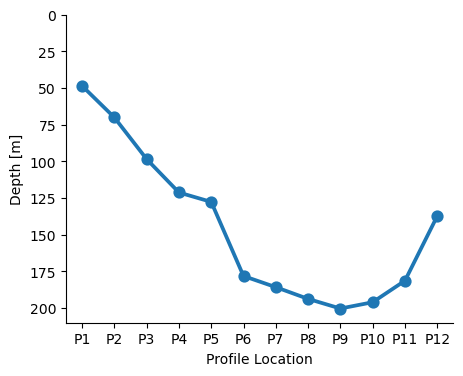

In [362]:
fig, ax = plt.subplots(figsize=(5, 4))

sns.pointplot(profile_locs, x='loc', y='depth', ax=ax)

ax.set_xlabel('Profile Location')
ax.set_ylabel('Depth [m]')
ax.spines[['right', 'top']].set_visible(False)
ax.set_ylim(0, 210)
ax.invert_yaxis()

plt.show()

### Oxygen Overturnings

In [15]:
def parse_metadata(md_file, location):
    md = pd.read_csv(md_file, sep='\t')[f'Mooring: {location}']

    # deployment and retrieval dates
    deploy_mask = md.str.startswith('Deployment').fillna(False)
    retrieve_mask = md.str.startswith('Retrieval').fillna(False)
    dt_deploy = datetime.strptime(md.loc[deploy_mask].iloc[0].split()[-1], "%d/%m/%Y")
    dt_retrieve = datetime.strptime(md.loc[retrieve_mask].iloc[0].split()[-1], "%d/%m/%Y")

    # Switzerland coordinates
    lon_mask = md.str.startswith('Longitude').fillna(False)
    lat_mask = md.str.startswith('Latitude').fillna(False)
    xsc = int(md.loc[lon_mask].iloc[0].split()[-1]) + int(2e6)
    ysc = int(md.loc[lat_mask].iloc[0].split()[-1]) + int(1e6)

    # total depth of mooring/lake at location
    total_depth = int(re.search(r'\d+', pd.read_csv(md_file, sep='\t').iloc[0][f'Mooring: {location}']).group())

    return {'dt_deploy': dt_deploy, 
            'dt_retrieve': dt_retrieve,
            'xsc': xsc,
            'ysc': ysc,
            'total_depth': total_depth}


def create_depth_map(md_file, total_depth):
    depth_map = pd.read_csv(md_file, sep='\t', names=['instrument', 'serial_id', 'mab', 'comments']).dropna(subset=('serial_id'))[1:].reset_index(drop=True)
    depth_map['mab'] = depth_map['mab'].astype(float)
    depth_map['depth'] = total_depth - depth_map['mab']
    
    return depth_map


def load_oxygen_data(data_dir, serial_id, depth_map):
    # file path to concatenated file with all days' data
    fpath = os.path.join(data_dir, f'7450-{serial_id}/Cat.TXT')

    # handle leading '0' in serial_id
    if serial_id != str(int(serial_id)):
        serial_id = str(int(serial_id))

    # read from .txt
    with open(fpath, 'r') as f:
        lines = [x[:-1] for x in f if len(x.split(',')) > 1]

    # extract column names and units
    cols = [x.lstrip(' ') for x in lines[0].split(',')]
    units = [x.lstrip(' ') for x in lines[1].split(',')]
    cols_units = [f'{c} {u}' for c, u in zip(cols, units)]

    data = []
    for line in lines[2:]:
        data.append((x.lstrip(' ') for x in line.split(',')))

    # store in dataframe
    data = pd.DataFrame(data, columns=cols_units)
    data['Unix Timestamp (Second)'] = data['Unix Timestamp (Second)'].astype(int)           # already in chronological order
    data['Temperature (deg C)'] = data['Temperature (deg C)'].astype(float)
    data['Dissolved Oxygen (mg/l)'] = data['Dissolved Oxygen (mg/l)'].astype(float)
    data['Dissolved Oxygen Saturation (%)'] = data['Dissolved Oxygen Saturation (%)'].astype(float)
    data['UTC_Date_&_Time (none)'] = pd.to_datetime(data['UTC_Date_&_Time (none)'])
    data['depth'] = depth_map.query('serial_id == @serial_id').iloc[0]['depth']

    return data


# calculate number of overturns, time length of overturns, and difference in o2 during overturns
# PME MiniDOT brochure says accuracy 0.3 mg/l
def calculate_overturn_time_intensity(d_low, d_comp, accuracy=0.3):
    mask = d_low > d_comp

    data = []
    prior = mask.values[0]
    for i in tqdm(range(1, len(mask))):
        current = mask.values[i]

        # start of overturning
        if current and not prior:
            t_start = mask['UTC_Date_&_Time (none)'][i].item()
            max_intensity = d_low.values[i] - d_comp.values[i]
            j = i + 1

            # time length and max intensity of overturning
            while mask[j]:
                intensity = d_low.values[j] - d_comp.values[j]
                if intensity > max_intensity:
                    max_intensity = intensity
                j += 1
            t_end = mask['UTC_Date_&_Time (none)'][j].item()

            data.append({'d_low': d_low.depth.item(), 'd_comp': d_comp.depth.item(), 
                        't_len': (t_end - t_start) / 1e9, 'intensity': max_intensity,
                        'acc1': max_intensity > accuracy, 'acc2': max_intensity > 2*accuracy})

        prior = current

    return pd.DataFrame(data)

#### January, February, March, April 2025

In [364]:
lake = 'Zugersee'
location = 'LZ1'
year = '2025'
date = '20250424'

data_dir = f'Q:/Messdaten/Aphys_hypothesis_data/{lake}/{year}/Mooring/{date}/{location}/'

md_file = f'Q:/Messdaten/Aphys_hypothesis_data/{lake}/{year}/Mooring/{date}/{date}_{location}_meta.tsv'

oxygen_loggers = [os.path.join(data_dir, o) for o in glob('7450-*', root_dir=data_dir)]

In [ ]:
md = parse_metadata(md_file, location)
depth_map = create_depth_map(md_file, md['total_depth'])
md

{'dt_deploy': datetime.datetime(2025, 1, 16, 0, 0),
 'dt_retrieve': datetime.datetime(2025, 4, 24, 0, 0),
 'xsc': 2680186,
 'ysc': 1281332,
 'total_depth': 187}

In [ ]:
oxygen_data = []
for o in tqdm(oxygen_loggers):
    serial_id = os.path.basename(o).split('-')[-1]
    data = load_oxygen_data(data_dir, serial_id, depth_map)

    # remove downcast and upcast     # TO DO: find optimal boundaries
    dt_min = data['UTC_Date_&_Time (none)'].min()
    dt_max = data['UTC_Date_&_Time (none)'].max()
    dt_start = dt_min + pd.Timedelta(hours=168)
    dt_end = dt_max - pd.Timedelta(hours=12)
    data = data[data['UTC_Date_&_Time (none)'].between(dt_start, dt_end)]

    data['serial_id'] = serial_id
    oxygen_data.append(data)

oxygen_data = pd.concat(oxygen_data, ignore_index=True)

  0%|          | 0/4 [00:00<?, ?it/s]

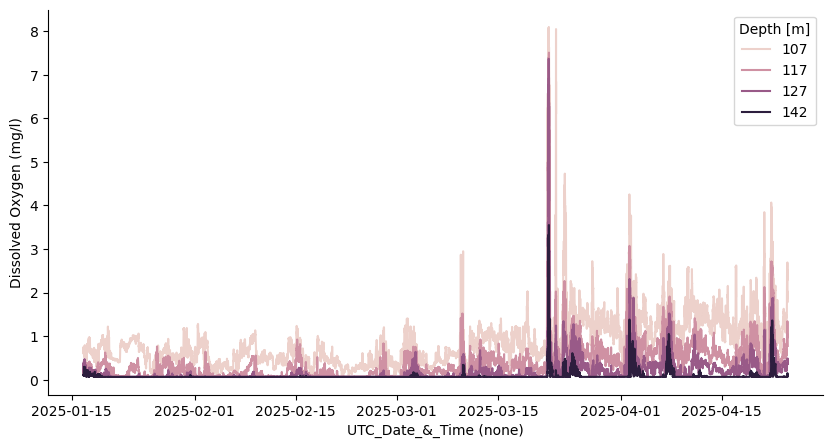

In [68]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.lineplot(oxygen_data, x='UTC_Date_&_Time (none)', y='Dissolved Oxygen (mg/l)', hue='depth', ax=ax)

ax.spines[['right', 'top']].set_visible(False)

handles, labels = ax.get_legend_handles_labels()
labels = [int(float(x)) for x in labels]
ax.legend(handles, labels, title='Depth [m]')

plt.show()

In [200]:
# minimum values -- lowest depth has lowest min, so overturning not calibration errors
oxygen_data.groupby('depth')['Dissolved Oxygen (mg/l)'].min()

depth
107.0    0.061
117.0    0.064
127.0    0.066
142.0    0.059
Name: Dissolved Oxygen (mg/l), dtype: float64

In [201]:
# timeseries of deepest oxygen logger
o2_ts = oxygen_data.query('depth == 142')['Dissolved Oxygen (mg/l)'].to_numpy()

# index of global maximum
o2_max_dt = oxygen_data.query('depth == 142').iloc[o2_ts.argmax()]['UTC_Date_&_Time (none)']

# oxyen data following global maximum
oxygen_data_post_gmax = oxygen_data[oxygen_data['UTC_Date_&_Time (none)'] >= o2_max_dt]

# timeseries of deepest oxygen logger following global maximum
o2_ts_post_gmax = oxygen_data_post_gmax.query('depth == 142')['Dissolved Oxygen (mg/l)'].to_numpy()

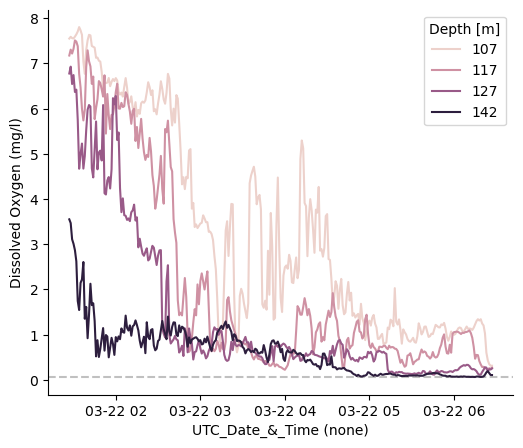

In [202]:
# zoom in on post max decrease
fig, ax = plt.subplots(figsize=(6, 5))

ax.axhline(o2_ts_post_gmax.min(), color='silver', ls='--')
sns.lineplot(oxygen_data_post_gmax[oxygen_data_post_gmax['UTC_Date_&_Time (none)'] <= o2_max_dt + pd.Timedelta(hours=5)], 
             x='UTC_Date_&_Time (none)', y='Dissolved Oxygen (mg/l)', hue='depth', ax=ax)

ax.spines[['right', 'top']].set_visible(False)

handles, labels = ax.get_legend_handles_labels()
labels = [int(float(x)) for x in labels]
ax.legend(handles, labels, title='Depth [m]')

plt.show()

In [203]:
# convert to xarray dataset
ds = oxygen_data.sort_values(['depth', 'UTC_Date_&_Time (none)']).set_index(['UTC_Date_&_Time (none)', 'depth']).to_xarray()
ds = ds.assign_coords(serial_id=('depth', oxygen_data.drop_duplicates('depth')['serial_id'].values))

In [222]:
overturn_data = []
d_low = ds.sel(depth=142)['Dissolved Oxygen (mg/l)']
for d in [127, 117, 107]:
    d_comp = ds.sel(depth=d)['Dissolved Oxygen (mg/l)']
    overturn_data.append(calculate_overturn_time_intensity(d_low, d_comp))

overturn_data = pd.concat(overturn_data, ignore_index=True)

  0%|          | 0/140454 [00:00<?, ?it/s]

  0%|          | 0/140454 [00:00<?, ?it/s]

  0%|          | 0/140454 [00:00<?, ?it/s]

In [226]:
overturn_data.groupby(['d_low', 'd_comp']).size(), overturn_data[overturn_data['acc1']].groupby(['d_low', 'd_comp']).size(),  overturn_data[overturn_data['acc2']].groupby(['d_low', 'd_comp']).size()

(d_low  d_comp
 142.0  107.0     21
        117.0     35
        127.0     95
 dtype: int64,
 d_low  d_comp
 142.0  107.0     1
        117.0     3
        127.0     6
 dtype: int64,
 d_low  d_comp
 142.0  127.0     2
 dtype: int64)

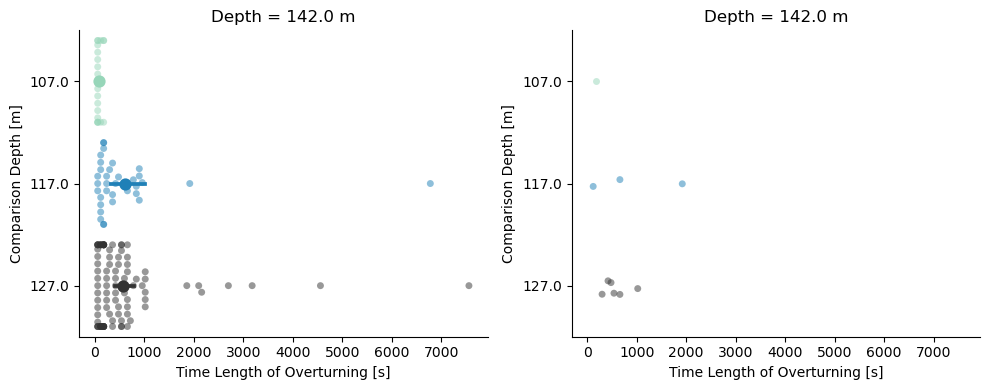

In [230]:
# time length of overturnings as a function of depth
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharex=True)

# all overturnings
sns.pointplot(overturn_data, x='t_len', y='d_comp', orient='y', hue='d_comp', palette='YlGnBu_d', ax=ax[0], legend=False)
sns.swarmplot(overturn_data, x='t_len', y='d_comp', orient='y', hue='d_comp', palette='YlGnBu_d', alpha=0.5, ax=ax[0], legend=False)

ax[0].set_xlabel('Time Length of Overturning [s]')
ax[0].set_ylabel('Comparison Depth [m]')
ax[0].set_title(f'Depth = {overturn_data.d_low.unique()[0]} m')

ax[0].spines[['right', 'top']].set_visible(False)

# overturnings intensity > accuracy
sns.stripplot(overturn_data[overturn_data['acc1']], x='t_len', y='d_comp', orient='y', hue='d_comp', palette='YlGnBu_d', alpha=0.5, ax=ax[1], legend=False)

ax[1].set_xlabel('Time Length of Overturning [s]')
ax[1].set_ylabel('Comparison Depth [m]')
ax[1].set_title(f'Depth = {overturn_data.d_low.unique()[0]} m')

ax[1].spines[['right', 'top']].set_visible(False)

plt.tight_layout()
plt.show()

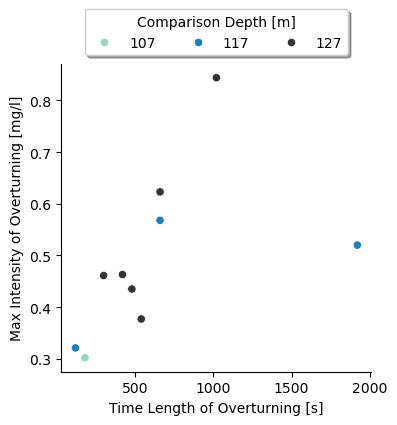

In [248]:
# time length of overturnings as function of max intensity of overturning
fig, ax = plt.subplots(figsize=(4, 4))

sns.scatterplot(overturn_data[overturn_data['acc1']], x='t_len', y='intensity', hue='d_comp', palette='YlGnBu_d', ax=ax)

ax.set_xlabel('Time Length of Overturning [s]')
ax.set_ylabel('Max Intensity of Overturning [mg/l]')

ax.spines[['right', 'top']].set_visible(False)

handles, labels = ax.get_legend_handles_labels()
labels = [int(float(x)) for x in labels]
ax.legend(handles, labels, title='Comparison Depth [m]', ncols=3, shadow=True, loc='upper center', bbox_to_anchor=(0.5, 1.2))

plt.show()

#### July, August, September, October 2024

In [3]:
lake = 'Zugersee'
location = 'LZ1'
year = '2024'
date = '20241017'

data_dir = f'Q:/Messdaten/Aphys_hypothesis_data/{lake}/{year}/Mooring/{location}/{date}/'

md_file = f'Q:/Messdaten/Aphys_hypothesis_data/{lake}/{year}/Mooring/{location}/{date}/{date}_{location}_meta.tsv'

oxygen_loggers = [os.path.join(data_dir, o) for o in glob('7450-*', root_dir=data_dir)]

In [5]:
md = parse_metadata(md_file, location)
depth_map = create_depth_map(md_file, md['total_depth'])
md

{'dt_deploy': datetime.datetime(2024, 7, 26, 0, 0),
 'dt_retrieve': datetime.datetime(2024, 10, 17, 0, 0),
 'xsc': 2680186,
 'ysc': 1281332,
 'total_depth': 188}

In [10]:
oxygen_data = []
for o in tqdm(oxygen_loggers):
    serial_id = os.path.basename(o).split('-')[-1]
    data = load_oxygen_data(data_dir, serial_id, depth_map)

    # remove downcast and upcast     # TO DO: find optimal boundaries
    dt_min = data['UTC_Date_&_Time (none)'].min()
    dt_max = data['UTC_Date_&_Time (none)'].max()
    dt_start = dt_min + pd.Timedelta(hours=168)
    dt_end = dt_max - pd.Timedelta(hours=12)
    data = data[data['UTC_Date_&_Time (none)'].between(dt_start, dt_end)]

    data['serial_id'] = serial_id
    oxygen_data.append(data)

oxygen_data = pd.concat(oxygen_data, ignore_index=True)

  0%|          | 0/4 [00:00<?, ?it/s]

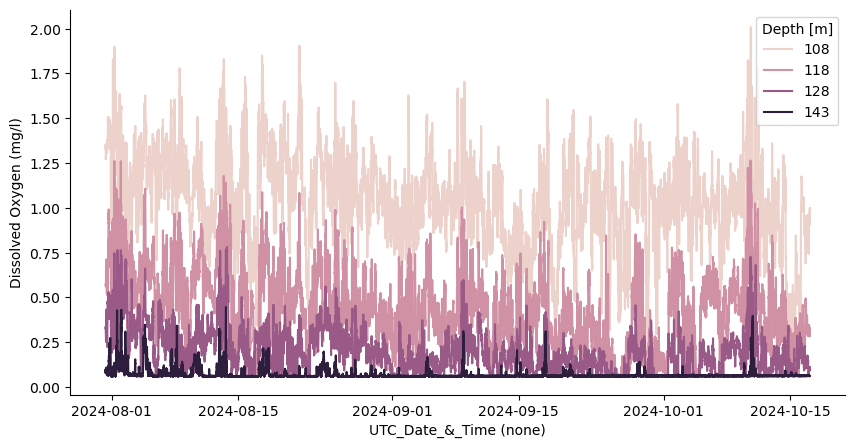

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.lineplot(oxygen_data, x='UTC_Date_&_Time (none)', y='Dissolved Oxygen (mg/l)', hue='depth', ax=ax)

ax.spines[['right', 'top']].set_visible(False)

handles, labels = ax.get_legend_handles_labels()
labels = [int(float(x)) for x in labels]
ax.legend(handles, labels, title='Depth [m]')

plt.show()

In [12]:
# convert to xarray dataset
ds = oxygen_data.sort_values(['depth', 'UTC_Date_&_Time (none)']).set_index(['UTC_Date_&_Time (none)', 'depth']).to_xarray()
ds = ds.assign_coords(serial_id=('depth', oxygen_data.drop_duplicates('depth')['serial_id'].values))

In [16]:
overturn_data = []
d_low = ds.sel(depth=143)['Dissolved Oxygen (mg/l)']
for d in [128, 118, 108]:
    d_comp = ds.sel(depth=d)['Dissolved Oxygen (mg/l)']
    overturn_data.append(calculate_overturn_time_intensity(d_low, d_comp))

overturn_data = pd.concat(overturn_data, ignore_index=True)

  0%|          | 0/112120 [00:00<?, ?it/s]

  0%|          | 0/112120 [00:00<?, ?it/s]

  0%|          | 0/112120 [00:00<?, ?it/s]

In [17]:
overturn_data.groupby(['d_low', 'd_comp']).size(), overturn_data[overturn_data['acc1']].groupby(['d_low', 'd_comp']).size(),  overturn_data[overturn_data['acc2']].groupby(['d_low', 'd_comp']).size()

(d_low  d_comp
 143.0  118.0     35
        128.0     69
 dtype: int64,
 Series([], dtype: int64),
 Series([], dtype: int64))

### CTD O2 Calibration Corrections

In [18]:
def calculate_bottom_min_o2(dsdf, group_var, xr_toggle):
    data = []

    for dt, profile in tqdm(dsdf.groupby(group_var)):
        try:
            if xr_toggle:
                profile = profile.sel(time=dt)
                dt = pd.to_datetime(dt)

                # bottom O2 concentration
                bottom_o2 = profile['bottom_oxy_conc'].item()

                # minimum O2 concentration
                min_o2 = profile['O2_conc'].min().item()
                idx = profile['O2_conc'].argmin()
                min_o2_depth = profile['depth'][idx].item()
                total_depth = profile['depth'].max().item()
            else:
                # bottom O2 concentration
                bottom_o2 = profile['oxygen'].iloc[-1]

                # minimum O2 concentration
                min_o2 = profile['oxygen'].min()
                idx = profile['oxygen'].argmin()
                min_o2_depth = profile['depth'].iloc[idx]
                total_depth = profile['depth'].max()
                
            data.append({
                'datetime': dt,
                'bottom_oxy_conc': bottom_o2,
                'min_oxy_conc': min_o2,
                'min_oxy_depth': min_o2_depth,
                'total_depth': total_depth
            })
        except ValueError:
            continue

    return pd.DataFrame(data)


def plot_bottom_min_o2(data, title):
    # reorganized dataframe
    dfp  = pd.melt(data, id_vars=['datetime'], value_vars=['bottom_oxy_conc', 'min_oxy_conc'],
                var_name='oxy_type', value_name='oxy_conc')

    fig, ax = plt.subplots(figsize=(8, 5))

    ax.axhline(0, color='black', ls='--')
    sns.lineplot(data=dfp, x='datetime', y='oxy_conc', hue='oxy_type', hue_order=['bottom_oxy_conc', 'min_oxy_conc'], ax=ax)

    ax.set_xlabel('Measurement Date')
    ax.set_ylabel('O$_2$ Concentration')
    ax.set_title(title)

    handles, _ = ax.get_legend_handles_labels()
    ax.legend(handles, ['Bottom O$_2$ Concentration', 'Minimum O$_2$ Concentration'])

    ax.spines[['right', 'top']].set_visible(False)


def plot_min_o2_depth(data, title):
    fig, ax = plt.subplots(figsize=(4, 4))

    sns.scatterplot(data, x='min_oxy_conc', y='min_oxy_depth')

    ax.set_xlabel('Minimum O$_2$ Concentration')
    ax.set_ylabel('Minimum O$_2$ Depth')
    ax.set_title(title)

    ax.invert_yaxis()

    ax.spines[['right', 'top']].set_visible(False)

    plt.show()

#### Cantonal CTD data from 2003-2025

In [19]:
root = '../../../data/lake_zug/ctd/canton_monitoring/'
all_profiles = [os.path.join(root, p) for p in glob('*.nc', root_dir=root)]
ds = xr.open_dataset(all_profiles[0])

ctd_data = calculate_bottom_min_o2(ds, 'time', True)

  0%|          | 0/243 [00:00<?, ?it/s]

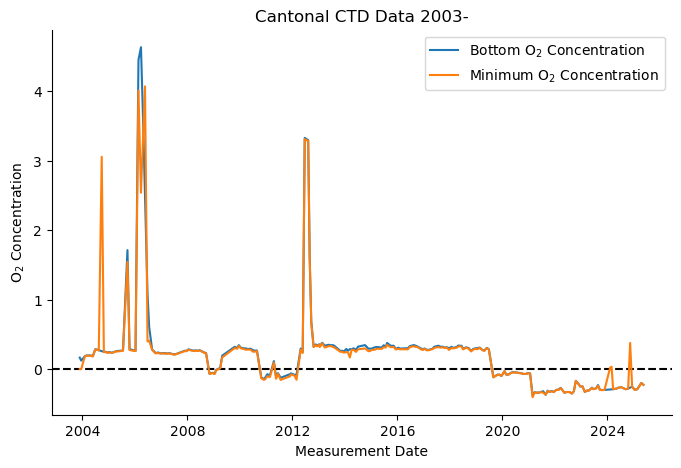

In [20]:
plot_bottom_min_o2(ctd_data, 'Cantonal CTD Data 2003-')

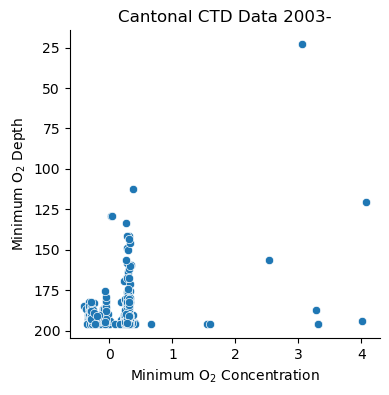

In [21]:
plot_min_o2_depth(ctd_data, 'Cantonal CTD Data 2003-')

#### Cantonal Monitoring Since 1950

In [ ]:
df = pd.read_csv('../../../data/lake_zug/cantonal.csv', header=[0, 1])
cols = df.columns.get_level_values(0)
df.columns = cols
df['date'] = pd.to_datetime(df['date'], dayfirst=True)
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

monitoring_data = calculate_bottom_min_o2(df, 'date', False)

  0%|          | 0/627 [00:00<?, ?it/s]

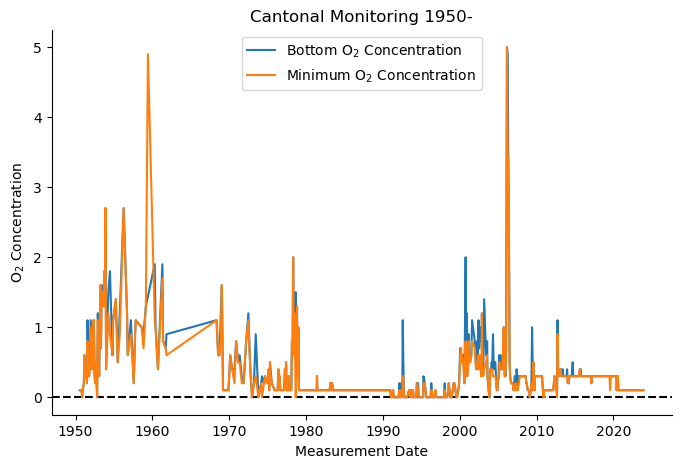

In [ ]:
plot_bottom_min_o2(monitoring_data, 'Cantonal Monitoring 1950-')

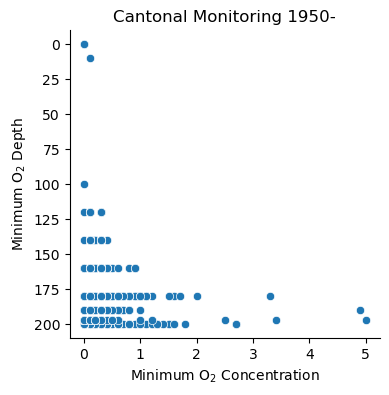

In [ ]:
plot_min_o2_depth(monitoring_data, 'Cantonal Monitoring 1950-')